# Image Classification using Dense Neural Network
- This tutorial covers developing a DNN model to classify image data.
- Dataset used for analysis is FMNIST image dataset available in Tensflow's dataset repository.
- A multiclass classification DNN in `Tensorflow` framework is developed to identify 10 different classes of fashion items.
- Next step is to use `keras_tuner.RandomSearch` to tune the parameters used in the development of base DNN model and thus increase its performance.

In [ ]:
# importing libraries necessary for data transformation, DNN development and tuning etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [ ]:
print(tf.__version__)
print(kt.__version__)

2.8.0
1.1.2


### I. Data Import and Pre-processing

In [ ]:
# Load the Fashion MNIST dataset
df_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
# Split Fashion MNIST dataset into test and training dataset : X and Y/Target variables also defined
(X_train, Y_train), (X_test, Y_test) = df_mnist.load_data()

In [ ]:
# Checking the dimensions of the datasets generated
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

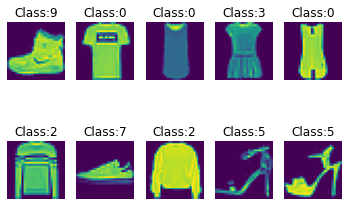

In [ ]:
# Print first 10 elements/images with their corresponding label in the training dataset

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title('Class:{}'.format(Y_train[i]))
    plt.axis('off')
    plt.grid(True)

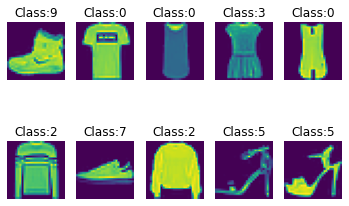

In [ ]:
# normalizing images in train and test dataset and visualzie them again
X_train  = X_train / 255.0
X_test = X_test / 255.0

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title('Class:{}'.format(Y_train[i]))
    plt.axis('off')
    plt.grid(True)

### II. Base DNN model development
- Building a baseline Dense Neural Network with 3 layers :
  - 64 units in Layer1
  - 64 units in Layer2
  - 10 units in Layer3 (Last layer has 10 units to classify 10 classes)

In [ ]:
# clear state
tf.keras.backend.clear_session()
np.random.seed(21)

In [ ]:
# develop base dnn
base_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
                                         tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                         tf.keras.layers.Dense(64, activation='relu'), 
                                         tf.keras.layers.Dense(10, activation='softmax')])

# Assign model hyperparameters
base_model.compile(optimizer = tf.optimizers.Adam(),
                   loss = 'sparse_categorical_crossentropy',
                   metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
base_model_history = base_model.fit(X_train, Y_train, validation_split=0.10,
                                    epochs=10, callbacks=[callback], batch_size=512)

Epoch 1/10
106/106 [==============================] - 3s 16ms/step - loss: 0.8139 - accuracy: 0.7256 - val_loss: 0.5028 - val_accuracy: 0.8233
Epoch 2/10
106/106 [==============================] - 1s 12ms/step - loss: 0.4714 - accuracy: 0.8369 - val_loss: 0.4441 - val_accuracy: 0.8405
Epoch 3/10
106/106 [==============================] - 1s 12ms/step - loss: 0.4287 - accuracy: 0.8512 - val_loss: 0.4206 - val_accuracy: 0.8525
Epoch 4/10
106/106 [==============================] - 1s 12ms/step - loss: 0.3997 - accuracy: 0.8617 - val_loss: 0.4070 - val_accuracy: 0.8608
Epoch 5/10
106/106 [==============================] - 1s 14ms/step - loss: 0.3774 - accuracy: 0.8683 - val_loss: 0.3948 - val_accuracy: 0.8593
Epoch 6/10
106/106 [==============================] - 1s 11ms/step - loss: 0.3621 - accuracy: 0.8737 - val_loss: 0.3756 - val_accuracy: 0.8710
Epoch 7/10
106/106 [==============================] - 1s 13ms/step - loss: 0.3514 - accuracy: 0.8770 - val_loss: 0.3989 - val_accuracy: 0.8568

In [ ]:
print(base_model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


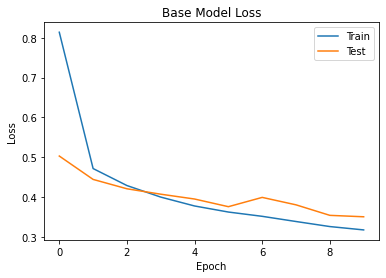

In [ ]:
# summarize history for loss
plt.plot(base_model_history.history['loss'])
plt.plot(base_model_history.history['val_loss'])
plt.title('Base Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

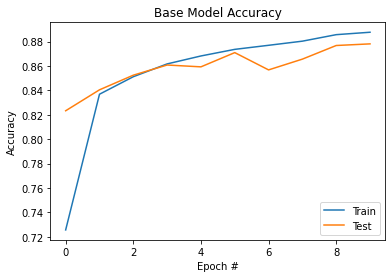

In [ ]:
# summarize history for accuracy
plt.plot(base_model_history.history['accuracy'])
plt.plot(base_model_history.history['val_accuracy'])
plt.title('Base Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model on Test data
result_dictionary = base_model.evaluate(X_test, Y_test, return_dict=True, verbose=0)
base_model_performance = pd.DataFrame([result_dictionary.values()],
                                       columns=[list(result_dictionary.keys())])
base_model_performance['loss'] = round((base_model_performance['loss']),4)
base_model_performance['accuracy'] = round((base_model_performance['accuracy'])*100,2)
base_model_performance.index = ['Base_Model']   
print('Model performance on Test data')
print(base_model_performance)

Model performance on Test data
              loss accuracy
Base_Model  0.3758    86.67


### III. Hyperparameter Tuning

In [ ]:
# define a tuner class with functions to build and fit a model with different combinations of hyperparamters

class MyHyperModel(kt.HyperModel):
  def build(self, hp):
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
      
      for i in range(hp.Int('num_layers', 1, 5)):
          model.add(tf.keras.layers.Dense(units=hp.Choice('units_{}'.format(i),
                                                           values=[16, 32, 64, 128]),
                                                           activation='relu'))
          
      model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
      
      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
      
      model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model 
  
  def fit(self, hp, model, *args, **kwargs):
    return model.fit(*args, batch_size=hp.Choice('batch_size', [128, 256, 512]), **kwargs, )

In [ ]:
# create a tuner object to develop hyperparameter search space

tuner = kt.RandomSearch(MyHyperModel(),
                        objective='val_accuracy',
                        max_trials=8,
                        overwrite = True,
                        directory='my_dir',
                        project_name='tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(21)

In [ ]:
# fit tuner object on train data to find best model hyperparameter combination

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 8 Complete [00h 00m 10s]
val_accuracy: 0.8725000023841858

Best val_accuracy So Far: 0.8802499771118164
Total elapsed time: 00h 02m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Assigning best hyperparameters from the results
best_hpt=tuner.get_best_hyperparameters()[0]
print('Total Layers {}'.format(best_hpt.get('num_layers')+1))
print('Tuned Alpha {}'.format(best_hpt.get('learning_rate')))
print('Tuned Batch Size {}'.format(best_hpt.get('batch_size')))

Total Layers 5
Tuned Alpha 0.001
Tuned Batch Size 128


In [ ]:
# Build tuned model
tuned_model = tuner.hypermodel.build(best_hpt)
tf.keras.backend.clear_session()
np.random.seed(21)

# Train the hypertuned model
tuned_model_history = tuned_model.fit(X_train, Y_train, epochs=10, validation_split=0.2,
                                      batch_size=best_hpt.get('batch_size'),
                                      callbacks=[stop_early], verbose=2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


375/375 - 2s - loss: 0.6417 - accuracy: 0.7782 - val_loss: 0.4533 - val_accuracy: 0.8386 - 2s/epoch - 6ms/step
Epoch 2/10
375/375 - 2s - loss: 0.4203 - accuracy: 0.8511 - val_loss: 0.4249 - val_accuracy: 0.8456 - 2s/epoch - 4ms/step
Epoch 3/10
375/375 - 2s - loss: 0.3743 - accuracy: 0.8655 - val_loss: 0.3926 - val_accuracy: 0.8583 - 2s/epoch - 4ms/step
Epoch 4/10
375/375 - 2s - loss: 0.3459 - accuracy: 0.8753 - val_loss: 0.3656 - val_accuracy: 0.8649 - 2s/epoch - 4ms/step
Epoch 5/10
375/375 - 2s - loss: 0.3281 - accuracy: 0.8799 - val_loss: 0.3497 - val_accuracy: 0.8710 - 2s/epoch - 4ms/step
Epoch 6/10
375/375 - 2s - loss: 0.3087 - accuracy: 0.8854 - val_loss: 0.3477 - val_accuracy: 0.8742 - 2s/epoch - 4ms/step
Epoch 7/10
375/375 - 2s - loss: 0.2930 - accuracy: 0.8919 - val_loss: 0.3375 - val_accuracy: 0.8813 - 2s/epoch - 4ms/step
Epoch 8/10
375/375 - 2s - loss: 0.2838 - accuracy: 0.8956 - val_loss: 0.3378 - val_accuracy: 0.8784 - 2s/epoch - 4ms/step
Epoch 9/10
375/375 - 2s - loss: 0.2

In [ ]:
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 69,226
Trainable params: 69,226
Non-trai

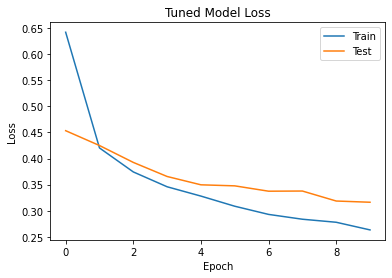

In [ ]:
# summarize history for loss
plt.plot(tuned_model_history.history['loss'])
plt.plot(tuned_model_history.history['val_loss'])
plt.title('Tuned Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

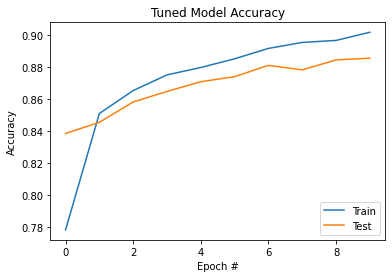

In [ ]:
# summarize history for accuracy
plt.plot(tuned_model_history.history['accuracy'])
plt.plot(tuned_model_history.history['val_accuracy'])
plt.title('Tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model on Test data
result_dictionary = tuned_model.evaluate(X_test, Y_test, return_dict=True, verbose=0)
tuned_model_performance = pd.DataFrame([result_dictionary.values()],
                                        columns=[list(result_dictionary.keys())])
tuned_model_performance['loss'] = round((tuned_model_performance['loss']),4)
tuned_model_performance['accuracy'] = round((tuned_model_performance['accuracy'])*100,2)
tuned_model_performance.index = ['Tuned_Model']   
tuned_model_performance

,loss,accuracy
Tuned_Model,0.346,87.61
